In [1]:
!pip install transformers

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import re
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BILAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
Category_model = BertForSequenceClassification.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')
Category_tokenizer = BertTokenizer.from_pretrained('Emran/ClinicalBERT_ICD10_Categories')


In [6]:
from transformers import pipeline, TextClassificationPipeline

Category_classifier = pipeline('text-classification', model = Category_model, tokenizer = Category_tokenizer)


In [4]:
diagnosis_sentences = [
    "The patient is a 70-year-old male with a history of congestive heart failure (CHF), polymyalgia rheumatica (PMR), hypertension (HTN), hyperlipidemia (HLD), and ulcerative colitis (UC), who presented with acute weakness and an inability to ambulate.",
    "Initial assessments revealed cardiomegaly, pulmonary edema, atrial fibrillation, and elevated troponin levels.",
    "The patient had taken gabapentin and trazodone prior to the onset of symptoms, which was deemed to be the cause of the pulmonary edema.",
    "Subsequent treatment included IV Lasix and aspirin, leading to the patient's improvement.",
    "The final diagnosis included weakness secondary to medication interaction, acute on chronic diastolic heart failure, and iatrogenic pulmonary edema from IV fluids.",
    "The patient was instructed to stop taking trazodone and gabapentin."
]

In [5]:
print((Category_classifier(diagnosis_sentences)))

[{'label': 'M80', 'score': 0.07665860652923584}, {'label': 'R53', 'score': 0.015815751627087593}, {'label': 'B95', 'score': 0.14357107877731323}, {'label': 'T45', 'score': 0.24647535383701324}, {'label': 'R53', 'score': 0.026163753122091293}, {'label': 'T37', 'score': 0.05987509340047836}]


In [10]:

sample_text = 'diabetic ketoacidosis none male with tdm presenting with dka from for the past days patient has felt myalgias fatigue general sensation of being run down and increasing nausea over the past few days yesterday patient felt very nauseous and found blood sugars to be s around lunchtime he took insulin and a nap and persisted in the high s patient has been compliant with his home insulin regimen there been no recent changes to his home insulin regimen however patient does note recent uritype symptoms with productive cough initially white then yellow then black sputum and feverschills earlier in the week that have improved he notes having taking theraflu which he believes may have had a lot of sugar he developed significant abdominal pain and nausea with initially nonbloody vomiting x and then with some scant bleeding with dry heaving and so presented to at he was found to be in dka'
print((Category_classifier(sample_text)))

[{'label': 'R42', 'score': 0.04846738278865814}]


In [85]:
hop_notes = pd.read_excel('100 HOPIs.xlsx')

In [86]:
hop_notes

,text
0,46YR OLD F HTN DM \nS/P LEFT MRM 20-4-19 AT TI...
1,19YRS OLD FEMALE\nCP CHILD\nREFRRED FROM OPD \...
2,k/c of htn non complient to medication \nc/o:\...
3,g2p1+0\n29+3 week with less fm\nfkc given\npat...
4,18YR OLD M NKCM \nPAST MED SURG HX UNREMARKABL...
...,...
109,nkcm\nhx of smoking \nc/o pain in left side of...
110,middle age male pt presented e\nnkc\nlower abd...
111,NKCM \nPRESENTED WITH C/O EPIGASTRIC PAIN SIN...
112,"g3p2+0,prev 2 c/s ,33 wks with c/o lap+backach..."


Average Length: 410.6842105263158
Smallest Length: 92
Largest Length: 985


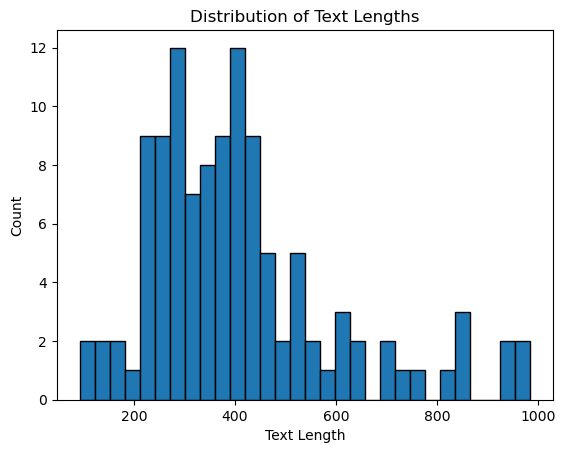

In [87]:
hop_notes['text_length'] = hop_notes['text'].apply(len)

# Find the average length, smallest length, and largest length
average_length = hop_notes['text_length'].mean()
smallest_length = hop_notes['text_length'].min()
largest_length = hop_notes['text_length'].max()

print("Average Length:", average_length)
print("Smallest Length:", smallest_length)
print("Largest Length:", largest_length)

# Plot the distribution of text lengths
plt.hist(hop_notes['text_length'], bins=30, edgecolor='k')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

#### Lets Create a Testing Dataset with 1000 clinical notes and smallest token length

In [18]:
notes_df = pd.read_csv('mimic_IV_dataset/discharge.csv')


In [19]:
notes_df.drop(columns = ['charttime', 'storetime', 'note_type', 'note_seq'], inplace = True)
combined_notes = notes_df.groupby('hadm_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
combined_notes

,hadm_id,text
0,20000019,\nName: ___ Unit No: ___\n \nA...
1,20000024,\nName: ___ Unit No: ___\n \n...
2,20000034,\nName: ___ Unit No: __...
3,20000041,\nName: ___ Unit No: ___\n \n...
4,20000057,\nName: ___ Unit No: ...
...,...,...
331789,29999670,\nName: ___ Unit No: _...
331790,29999723,\nName: ___ Unit No: __...
331791,29999745,\nName: ___ Unit No: ___\n...
331792,29999809,\nName: ___ Unit No: ___\...


In [7]:
# Define the reformat function
def reformat(code):
    code = ''.join(code.split('.'))
    code = code[:3] + '.'
    return code

In [40]:
diagnoses_df = pd.read_csv('mimic_IV_dataset/diagnoses_icd.csv')
print(diagnoses_df.shape)
diagnoses_df = diagnoses_df[diagnoses_df.icd_version == 10]

diagnoses_df['icd_code'] = diagnoses_df['icd_code'].astype(str)

diagnoses_df['icd_code'] = diagnoses_df['icd_code'].apply(lambda x: reformat(x))
diagnoses_df.reset_index(drop = True, inplace = True)

diagnoses_df['hadm_id'] = diagnoses_df['hadm_id'].astype(str)
combined_notes['hadm_id'] = combined_notes['hadm_id'].astype(str)

(4756326, 5)


In [41]:
combined_notes_with_icd = pd.merge(combined_notes, diagnoses_df, on='hadm_id', how='left')
combined_notes_with_icd
print(combined_notes_with_icd.shape)
combined_notes_with_icd.isnull().sum()

(1974923, 7)


hadm_id             0
text                0
text_length         0
subject_id     209493
seq_num        209493
icd_code       209493
icd_version    209493
dtype: int64

In [42]:
combined_notes_with_icd.dropna(inplace = True)
print(combined_notes_with_icd.shape)
combined_notes_with_icd.isnull().sum()

(1765430, 7)


hadm_id        0
text           0
text_length    0
subject_id     0
seq_num        0
icd_code       0
icd_version    0
dtype: int64

In [48]:
unique_notes_with_hadm_id = combined_notes_with_icd[['hadm_id', 'text']]
unique_notes_with_hadm_id.drop_duplicates(inplace = True)

C:\Users\BILAL\AppData\Local\Temp\ipykernel_15076\1368439941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_notes_with_hadm_id.drop_duplicates(inplace = True)


In [57]:
unique_notes_with_hadm_id.reset_index(drop = True, inplace = True)
unique_notes_with_hadm_id

,hadm_id,text,text_length
0,20000024,\nName: ___ Unit No: ___\n \n...,8959
1,20000034,\nName: ___ Unit No: __...,6319
2,20000094,\nName: ___ Unit No: _...,4930
3,20000147,\nName: ___ Unit No: __...,10306
4,20000239,\nName: ___ Unit No: ___\n \nA...,14392
...,...,...,...
122296,29999090,\nName: ___. Unit No: ___\...,9657
122297,29999127,\nName: ___ Unit No: ...,6912
122298,29999457,\nName: ___ Unit No: ___\n ...,10787
122299,29999501,\nName: ___ Unit No: ...,6791


In [51]:
icd_codes_with_hadm_id = combined_notes_with_icd[['hadm_id', 'icd_code']]
icd_codes_with_hadm_id

,hadm_id,icd_code
1,20000024,D50.
2,20000024,K52.
3,20000024,I10.
4,20000024,E53.
5,20000024,M81.
...,...,...
1974913,29999625,R47.
1974914,29999625,E78.
1974915,29999625,Z96.
1974916,29999625,N14.


Average Length: 11545.965413201855
Smallest Length: 598
Largest Length: 58596


C:\Users\BILAL\AppData\Local\Temp\ipykernel_15076\2866819125.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_notes_with_hadm_id['text_length'] = unique_notes_with_hadm_id['text'].apply(len)


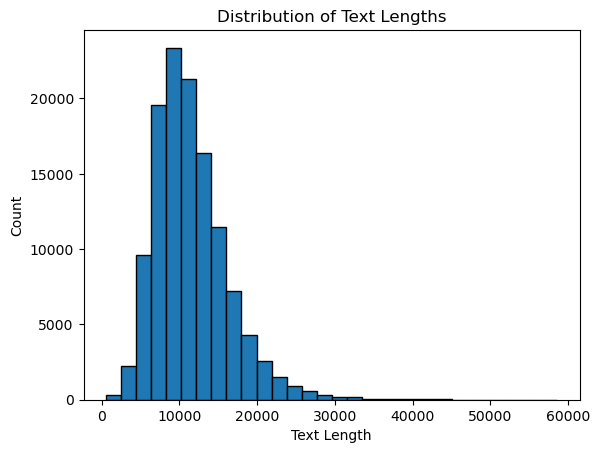

In [53]:
unique_notes_with_hadm_id['text_length'] = unique_notes_with_hadm_id['text'].apply(len)

# Find the average length, smallest length, and largest length
average_length = unique_notes_with_hadm_id['text_length'].mean()
smallest_length = unique_notes_with_hadm_id['text_length'].min()
largest_length = unique_notes_with_hadm_id['text_length'].max()

print("Average Length:", average_length)
print("Smallest Length:", smallest_length)
print("Largest Length:", largest_length)

# Plot the distribution of text lengths
plt.hist(unique_notes_with_hadm_id['text_length'], bins=30, edgecolor='k')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [ ]:
unique_notes_with_hadm_id['text_length'] = unique_notes_with_hadm_id['text'].apply(len)

# Find the average length, smallest length, and largest length
average_length = unique_notes_with_hadm_id['text_length'].mean()
smallest_length = unique_notes_with_hadm_id['text_length'].min()
largest_length = unique_notes_with_hadm_id['text_length'].max()

print("Average Length:", average_length)
print("Smallest Length:", smallest_length)
print("Largest Length:", largest_length)

# Plot the distribution of text lengths
plt.hist(unique_notes_with_hadm_id['text_length'], bins=30, edgecolor='k')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [73]:
testing_notes_with_smallest_size = unique_notes_with_hadm_id[unique_notes_with_hadm_id.text_length<3500].reset_index(drop = True)

In [74]:
testing_notes_with_smallest_size.to_csv('1000_testing_notes_with_smallest_size.csv')

In [8]:
testing_notes_with_smallest_size = pd.read_csv('1000_testing_notes_with_smallest_size.csv')

In [9]:
testing_notes_with_smallest_size.drop(columns = ['Unnamed: 0'], inplace = True)

In [75]:
icd_codes_with_smallest_size_notes= icd_codes_with_hadm_id[icd_codes_with_hadm_id['hadm_id'].isin(testing_notes_with_smallest_size['hadm_id'].unique())].reset_index(drop = True)

In [77]:
icd_codes_with_smallest_size_notes.to_csv('icd_codes_for_1000_testing_notes_with_smallest_size.csv')

In [10]:
icd_codes_with_smallest_size_notes = pd.read_csv('icd_codes_for_1000_testing_notes_with_smallest_size.csv')

In [11]:
icd_codes_with_smallest_size_notes.drop(columns = ['Unnamed: 0'], inplace = True)

In [12]:
final_notes_with_icd_codes = pd.merge(testing_notes_with_smallest_size, icd_codes_with_smallest_size_notes, on='hadm_id', how='left')
final_notes_with_icd_codes

,hadm_id,text,text_length,icd_code
0,20019282,\nName: ___ Unit No: ___\n...,2480,S82.
1,20019282,\nName: ___ Unit No: ___\n...,2480,Z72.
2,20019282,\nName: ___ Unit No: ___\n...,2480,W10.
3,20019282,\nName: ___ Unit No: ___\n...,2480,Y92.
4,20022343,\nName: ___ Unit No: _...,3001,O60.
...,...,...,...,...
8580,29990058,\nName: ___ Unit No: ___\n...,3051,Z30.
8581,29990058,\nName: ___ Unit No: ___\n...,3051,Z23.
8582,29990058,\nName: ___ Unit No: ___\n...,3051,Z86.
8583,29990058,\nName: ___ Unit No: ___\n...,3051,K21.


Average Length: 2739.5733990147783
Smallest Length: 598
Largest Length: 3499


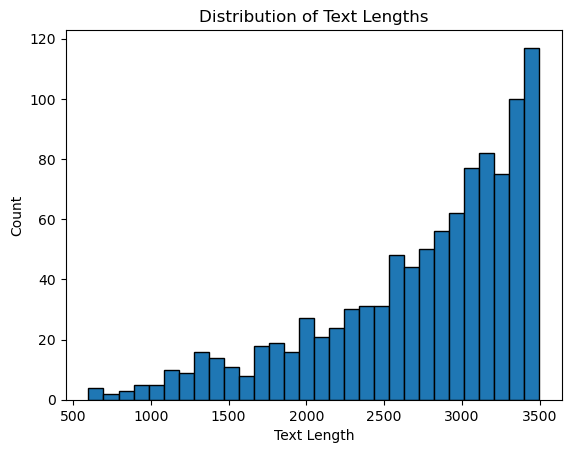

In [80]:
testing_notes_with_smallest_size['text_length'] = testing_notes_with_smallest_size['text'].apply(len)

# Find the average length, smallest length, and largest length
average_length = testing_notes_with_smallest_size['text_length'].mean()
smallest_length = testing_notes_with_smallest_size['text_length'].min()
largest_length = testing_notes_with_smallest_size['text_length'].max()

print("Average Length:", average_length)
print("Smallest Length:", smallest_length)
print("Largest Length:", largest_length)

# Plot the distribution of text lengths
plt.hist(testing_notes_with_smallest_size['text_length'], bins=30, edgecolor='k')
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

In [13]:
final_notes_with_icd_codes.icd_code.nunique()

769

In [14]:
final_notes_with_icd_codes.hadm_id.value_counts()

25784157    39
23040190    39
26295910    38
20101637    36
23314081    34
            ..
24813315     1
26644578     1
28990856     1
28290893     1
21647260     1
Name: hadm_id, Length: 1015, dtype: int64

In [21]:
example = final_notes_with_icd_codes.text[100]
example

' \nName:  ___                  Unit No:   ___\n \nAdmission Date:  ___              Discharge Date:   ___\n \nDate of Birth:  ___             Sex:   F\n \nService: CARDIOTHORACIC\n \nAllergies: \nNo Known Allergies / Adverse Drug Reactions\n \nAttending: ___.\n \nChief Complaint:\nacute respiratory failure\n \nMajor Surgical or Invasive Procedure:\nbronchoscopy x3\n\n \nHistory of Present Illness:\nFrom OMR:\nHISTORY OF PRESENT ___ former smoker (___) who \npresented with dry cough for the past six months. Evaluation for \nthis included a chest CT ___ which showed a right upper lobe \nmass with associated paratracheal lymphadenopathy. She underwent \nEBUS/TBNA ___ that had path of the RUL mass return as \nkeratinizing squamous cell ca. Level 4R and 7 were negative. Her \nPET-CT ___ noted an FDG avid (SUV 20) 5.5 x 6.5 cm right \nupper lobe mass abutting mediastinal and parietal pleura. She \nunderwent right thoracotomy and right pneumonectomy \n___ by pseudomonas PNA and respiratory f

In [22]:
final_notes_with_icd_codes[final_notes_with_icd_codes.hadm_id=='20101637']

,hadm_id,text,text_length,icd_code


In [23]:
testing_notes_with_smallest_size

,hadm_id,text,text_length
0,20019282,\nName: ___ Unit No: ___\n...,2480
1,20022343,\nName: ___ Unit No: _...,3001
2,20025548,\nName: ___ Unit No: ___\n...,2961
3,20027416,\nName: ___ Unit No: ___\n...,1059
4,20028418,\nName: ___ Unit No: ___\n \...,1091
...,...,...,...
1010,29980814,\nName: ___ Unit No: _...,3329
1011,29980930,\nName: ___ Unit No: ___...,1094
1012,29987299,\nName: ___ Unit No: ___\...,2595
1013,29988390,\nName: ___ Unit No: ...,3013


In [24]:
final_notes_with_icd_codes.hadm_id.nunique()

1015

In [15]:
medical_stopwords = stopwords.words("english")


medical_stopwords.extend(['speaking', 'none', 'time', 'flush'])

In [16]:
def process_clinical_note(clinical_note):
    # Define the sections to remove
    sections_to_remove = [
        "Name:",
        "Unit No:",
        "Admission Date:",
        "Discharge Date:",
        "Date of Birth:",
        "Sex:",
        "Service:",
        "Allergies:",
        "Attending:",
        "Past Medical History:",
        "Social History:",
        "Family History:",
        "Vitals:",
        "Pertinent Results:",
        "Medications on Admission:",
        "Discharge Medications:",
        "Discharge Disposition:",
        "Discharge Condition:",
        "Discharge Instructions:",
        "Followup Instructions:"
    ]

    # Split the clinical note into lines
    lines = clinical_note.split('\n')

    # Initialize the processed note
    processed_note = []

    # Flag to exclude lines within unwanted sections
    exclude_section = False

    # Iterate through the lines and filter unwanted sections
    for line in lines:
        if any(section in line for section in sections_to_remove):
            exclude_section = True
        elif line.strip() == "":
            # Empty lines separate sections, so reset the flag
            exclude_section = False

        if not exclude_section:
            processed_note.append(line)

    # Join the lines to create the final note
    final_note = '\n '.join(processed_note)
    
    sections_to_remove = [
        r'chief complaint',
        r'history of present illness',
        r'Major Surgical or Invasive Procedure',
        r'physical exam',
        r'brief hospital course',
        r'Discharge',
        
        r'completed by',
    ]
    
    for pattern in sections_to_remove:
        final_note = re.sub(pattern, '', final_note, flags=re.IGNORECASE)

    # Define patterns to identify negations
    negation_patterns = [
        r'no\s+\w+',
        r'not\s+\w+',
        r'did\s+not\s+have\s+\w+'
    ]
    
    # Filter out sentences with negations
    sentences = [sentence for sentence in final_note.split('\n') if not any(re.search(pattern, sentence, re.IGNORECASE) for pattern in negation_patterns)]

    # Remove keys and special characters
    cleaned_note = re.sub(r'\w+:', '', '\n'.join(sentences), flags=re.IGNORECASE)  # Remove keys (case-insensitive)
    cleaned_note = re.sub(r'[^a-zA-Z\s]', '', cleaned_note)  # Remove special characters
    # Tokenize the note into sentences based on '\n'
    sentences = [sentence.strip() for sentence in cleaned_note.split('\n') if sentence.strip()]

    # Remove stop words and empty sentences
    sentences = [
        ' '.join(word for word in sentence.split() if word.lower() not in medical_stopwords)
        for sentence in sentences
    ]
    sentences = [item for item in sentences if item != '']

    return sentences

In [27]:
process_clinical_note(final_notes_with_icd_codes.text[200])

['Rupture Aortic Anuerysm',
 'Endovascular Aortic Aneurysm Repair',
 'male known thoracoabdominal',
 'aortic aneurysm presented severe back pain',
 'hypertension Upon presentation ED patient',
 'complaining severe pain blood pressure',
 'history known aneurysm obtained Bedside',
 'ultrasound confirmed aneurysm periaortic fluid',
 'Vascular surgery called stat evaluation patient',
 'alert however unable communicate',
 'HR SBP satting nonrebreather',
 'pale obvious distress alert interactive',
 'breathing comfortably',
 'RRR',
 'mildly distended',
 'cold clammy',
 'expired',
 'patient presented ED ruptured aortic aneurysm',
 'taken CT scanner brought',
 'endovascular repair decompressive laparotomy',
 'case continued ongoing bleeding abdomen',
 'requiring massive transfusion maintain blood pressure',
 'despite multiple pressors Given poor prognosis ongoing',
 'bleeding family bedside decision',
 'made stop transfusing passed away shortly',
 'Rupture Aortic Aneurysm']

In [96]:
process_clinical_note(final_notes_with_icd_codes.text[100])

['acute respiratory failure',
 'bronchoscopy x',
 'HISTORY PRESENT former smoker',
 'presented dry cough past six months Evaluation',
 'included chest CT showed right upper lobe',
 'mass associated paratracheal lymphadenopathy underwent',
 'EBUSTBNA path RUL mass return',
 'keratinizing squamous cell ca Level R negative',
 'PETCT noted FDG avid SUV x cm right',
 'upper lobe mass abutting mediastinal parietal pleura',
 'underwent right thoracotomy right pneumonectomy',
 'pseudomonas PNA respiratory failure',
 'sp trachPEG recurrent worsening left lung',
 'consolidation treated PNA',
 'rehab earlier today returned hospital acute',
 'respiratory failure likely secondary morphine Ativan',
 'administration',
 'deceased',
 'patient rehab prolonged',
 'hospital stay sp pneumonectomy However hours',
 'arriving rehab facility patient desaturated',
 'FiO brought back hospital urgent',
 'bronchoscopy Bronchoscopy ED negative mucus',
 'plugging questionable malacia component pt',
 'admitted TSICU 

In [28]:
example_2 = ' \nName:  ___                   Unit No:   ___\n \nAdmission Date:  ___              Discharge Date:   ___\n \nDate of Birth:  ___             Sex:   F\n \nService: MEDICINE\n \nAllergies: \nNo Known Allergies / Adverse Drug Reactions\n \nAttending: ___\n \nChief Complaint:\nInpatient Hospice\n \nMajor Surgical or Invasive Procedure:\nnone\n\n \nHistory of Present Illness:\nPatient was admitted to inpatient hospice at ___. For full H&P \nsee prior discharge summary or admission note.\n \nPast Medical History:\nEtOH cirrhosis  \nCalculus of gallbladder without cholecystitis  \nCOPD  \nFatty liver  \nIron deficiency anemia  \nh/o aspiration pneumonitis  \n\nPast Surgical History:\ns/p partial gastrectomy ___ for ulcers\n"revision" of gastric ulcer surgery in ___ \n\n \nSocial History:\n___\nFamily History:\nMother w/ DM and ESRD on HD  \nNo family members with liver disease. \n\n \nPhysical Exam:\nAdmission to inpatient hospice exam:\nPatient lying comfortably in bed, sleeping. Breathing unlabored.\n\nDeath exam:\nPatient not breathing. No breath or heart sounds. No palpable\npulse. No pupillary reflexes. No withdrawal to firm nailbed\npressure.\nTime of death: ___\n \nPertinent Results:\nSee prior discharge summary for full lab results and other \nstudies. No labs or studies performed while patient on inpatient \nhospice.\n \nBrief Hospital Course:\nPatient admitted to inpatient hospice. Pain and agitation \nmedications were titrated. Medications to manage secretions were \nadded. Patient expired on ___ at ___.\n \nMedications on Admission:\nThe Preadmission Medication list is accurate and complete.\n1. Acetaminophen 500 mg PO Q6H:PRN Pain - Mild/Fever \n2. Albuterol 0.083% Neb Soln 1 NEB IH Q6H:PRN Wheezing, SOB \n3. Cepacol (Sore Throat Lozenge) 1 LOZ PO Q2H:PRN Throat \nirritation  \n4. GuaiFENesin ___ mL PO Q6H:PRN Cough  \n5. Haloperidol 0.5-2 mg IV Q4H:PRN delirium \n6. Heparin Flush (10 units/ml) 1 mL IV DAILY and PRN, VIP line \nflush \n7. Heparin Flush (10 units/ml) 2 mL IV DAILY and PRN, line flush \n\n8. HYDROmorphone (Dilaudid) 0.25-0.5 mg IV Q15MIN:PRN \nmoderate-severe pain or respiratory distress \n9. LORazepam 0.5-2 mg IV Q2H:PRN anxiety, nausea (first line) \n10. Midodrine 20 mg PO Q6H \n11. Ondansetron 4 mg IV Q8H:PRN Nausea/Vomiting - Second Line \n12. Polyethylene Glycol 17 g PO DAILY:PRN Constipation - First \nLine \n13. rifAXIMin 550 mg PO BID \n14. Simethicone 40-80 mg PO QID:PRN bloating \n15. Sodium Chloride 0.9%  Flush 10 mL IV DAILY and PRN, line \nflush \n16. Sodium Chloride 0.9%  Flush 10 mL IV DAILY and PRN, line \nflush \n\n \nDischarge Medications:\nnone\n \nDischarge Disposition:\nExpired\n \nDischarge Diagnosis:\n#Renal failure\n#Liver failure\n#VRE bloodstream infection\n#Spontaneous bacterial peritonitis\n#Alcoholic cirrhosis\n\n \nDischarge Condition:\npatient expired\n\n \nDischarge Instructions:\nPatient expired\n \nFollowup Instructions:\n___\n'

In [29]:
diagnosis_sentences = process_clinical_note(final_notes_with_icd_codes.text[200])
diagnosis_sentences

['Rupture Aortic Anuerysm',
 'Endovascular Aortic Aneurysm Repair',
 'male known thoracoabdominal',
 'aortic aneurysm presented severe back pain',
 'hypertension Upon presentation ED patient',
 'complaining severe pain blood pressure',
 'history known aneurysm obtained Bedside',
 'ultrasound confirmed aneurysm periaortic fluid',
 'Vascular surgery called stat evaluation patient',
 'alert however unable communicate',
 'HR SBP satting nonrebreather',
 'pale obvious distress alert interactive',
 'breathing comfortably',
 'RRR',
 'mildly distended',
 'cold clammy',
 'expired',
 'patient presented ED ruptured aortic aneurysm',
 'taken CT scanner brought',
 'endovascular repair decompressive laparotomy',
 'case continued ongoing bleeding abdomen',
 'requiring massive transfusion maintain blood pressure',
 'despite multiple pressors Given poor prognosis ongoing',
 'bleeding family bedside decision',
 'made stop transfusing passed away shortly',
 'Rupture Aortic Aneurysm']

In [30]:
predicted_codes = (Category_classifier(diagnosis_sentences))

In [31]:
predicted_codes

[{'label': 'I71', 'score': 0.8061150312423706},
 {'label': 'I71', 'score': 0.32476353645324707},
 {'label': 'N50', 'score': 0.05289603769779205},
 {'label': 'I71', 'score': 0.7084628939628601},
 {'label': 'I15', 'score': 0.47933855652809143},
 {'label': 'R30', 'score': 0.12670347094535828},
 {'label': 'Z87', 'score': 0.7746477723121643},
 {'label': 'I77', 'score': 0.22155673801898956},
 {'label': 'Z71', 'score': 0.9039456248283386},
 {'label': 'G24', 'score': 0.054240237921476364},
 {'label': 'R03', 'score': 0.03539000451564789},
 {'label': 'R40', 'score': 0.15721139311790466},
 {'label': 'R06', 'score': 0.9802731275558472},
 {'label': 'R00', 'score': 0.1434052586555481},
 {'label': 'R14', 'score': 0.9741264581680298},
 {'label': 'L08', 'score': 0.9486435055732727},
 {'label': 'P13', 'score': 0.032649531960487366},
 {'label': 'I71', 'score': 0.40481022000312805},
 {'label': 'R94', 'score': 0.16482879221439362},
 {'label': 'K94', 'score': 0.3067346215248108},
 {'label': 'R10', 'score': 

In [33]:
testing_notes_with_smallest_size

,hadm_id,text,text_length
0,20019282,\nName: ___ Unit No: ___\n...,2480
1,20022343,\nName: ___ Unit No: _...,3001
2,20025548,\nName: ___ Unit No: ___\n...,2961
3,20027416,\nName: ___ Unit No: ___\n...,1059
4,20028418,\nName: ___ Unit No: ___\n \...,1091
...,...,...,...
1010,29980814,\nName: ___ Unit No: _...,3329
1011,29980930,\nName: ___ Unit No: ___...,1094
1012,29987299,\nName: ___ Unit No: ___\...,2595
1013,29988390,\nName: ___ Unit No: ...,3013


In [17]:
testing_notes_with_smallest_size['sentences'] = testing_notes_with_smallest_size['text'].apply(process_clinical_note)
testing_notes_with_smallest_size

,hadm_id,text,text_length,sentences
0,20019282,\nName: ___ Unit No: ___\n...,2480,"[Left ankle fracture, ORIF left ankle, yr old ..."
1,20022343,\nName: ___ Unit No: _...,3001,"[Preterm labor, repeat low transverse cesarean..."
2,20025548,\nName: ___ Unit No: ___\n...,2961,"[contractions, SVD, Pt arrives co painful cont..."
3,20027416,\nName: ___ Unit No: ___\n...,1059,"[neck cancer, direct laryngoscopy robotic hemi..."
4,20028418,\nName: ___ Unit No: ___\n \...,1091,"[admission chemo, Pt tolerated desens without ..."
...,...,...,...,...
1010,29980814,\nName: ___ Unit No: _...,3329,"[Postpartum incision check, partial opening pa..."
1011,29980930,\nName: ___ Unit No: ___...,1094,"[elective chemotherapy, Pt presented elective ..."
1012,29987299,\nName: ___ Unit No: ___\...,2595,"[attach, BLOOD WBC RBC Hgb Hct, MCV MCH MCHC R..."
1013,29988390,\nName: ___ Unit No: ...,3013,"[acute cholecystitis, laparoscopic cholecystec..."


In [18]:
testing_notes_with_smallest_size

,hadm_id,text,text_length,sentences
0,20019282,\nName: ___ Unit No: ___\n...,2480,"[Left ankle fracture, ORIF left ankle, yr old ..."
1,20022343,\nName: ___ Unit No: _...,3001,"[Preterm labor, repeat low transverse cesarean..."
2,20025548,\nName: ___ Unit No: ___\n...,2961,"[contractions, SVD, Pt arrives co painful cont..."
3,20027416,\nName: ___ Unit No: ___\n...,1059,"[neck cancer, direct laryngoscopy robotic hemi..."
4,20028418,\nName: ___ Unit No: ___\n \...,1091,"[admission chemo, Pt tolerated desens without ..."
...,...,...,...,...
1010,29980814,\nName: ___ Unit No: _...,3329,"[Postpartum incision check, partial opening pa..."
1011,29980930,\nName: ___ Unit No: ___...,1094,"[elective chemotherapy, Pt presented elective ..."
1012,29987299,\nName: ___ Unit No: ___\...,2595,"[attach, BLOOD WBC RBC Hgb Hct, MCV MCH MCHC R..."
1013,29988390,\nName: ___ Unit No: ...,3013,"[acute cholecystitis, laparoscopic cholecystec..."


In [19]:
testing_notes_with_smallest_size['predictions'] = testing_notes_with_smallest_size['sentences'].apply(Category_classifier)
testing_notes_with_smallest_size

,hadm_id,text,text_length,sentences,predictions
0,20019282,\nName: ___ Unit No: ___\n...,2480,"[Left ankle fracture, ORIF left ankle, yr old ...","[{'label': 'S92', 'score': 0.9396796822547913}..."
1,20022343,\nName: ___ Unit No: _...,3001,"[Preterm labor, repeat low transverse cesarean...","[{'label': 'O60', 'score': 0.23506443202495575..."
2,20025548,\nName: ___ Unit No: ___\n...,2961,"[contractions, SVD, Pt arrives co painful cont...","[{'label': 'I51', 'score': 0.03336596861481666..."
3,20027416,\nName: ___ Unit No: ___\n...,1059,"[neck cancer, direct laryngoscopy robotic hemi...","[{'label': 'C7B', 'score': 0.05322039127349853..."
4,20028418,\nName: ___ Unit No: ___\n \...,1091,"[admission chemo, Pt tolerated desens without ...","[{'label': 'Z51', 'score': 0.17523302137851715..."
...,...,...,...,...,...
1010,29980814,\nName: ___ Unit No: _...,3329,"[Postpartum incision check, partial opening pa...","[{'label': 'O90', 'score': 0.867046058177948},..."
1011,29980930,\nName: ___ Unit No: ___...,1094,"[elective chemotherapy, Pt presented elective ...","[{'label': 'Z51', 'score': 0.09310486167669296..."
1012,29987299,\nName: ___ Unit No: ___\...,2595,"[attach, BLOOD WBC RBC Hgb Hct, MCV MCH MCHC R...","[{'label': 'N64', 'score': 0.09399197995662689..."
1013,29988390,\nName: ___ Unit No: ...,3013,"[acute cholecystitis, laparoscopic cholecystec...","[{'label': 'K81', 'score': 0.9844509363174438}..."


In [37]:
testing_notes_with_smallest_size['predictions'][0]

[{'label': 'S92', 'score': 0.9396796822547913},
 {'label': 'M25', 'score': 0.09078805893659592},
 {'label': 'V51', 'score': 0.038255129009485245},
 {'label': 'Z01', 'score': 0.10759342461824417},
 {'label': 'M25', 'score': 0.5484964847564697},
 {'label': 'Y83', 'score': 0.6605539917945862},
 {'label': 'E72', 'score': 0.09449656307697296},
 {'label': 'M25', 'score': 0.18133890628814697},
 {'label': 'Z47', 'score': 0.3548027276992798},
 {'label': 'Z47', 'score': 0.0813959389925003},
 {'label': 'S92', 'score': 0.8356196880340576}]

In [21]:
# Create the resultant DataFrame
result_df = pd.DataFrame()

for index, row in testing_notes_with_smallest_size.iterrows():
    hadm_id = str(row['hadm_id'])
    predictions = row['predictions']

    # Dictionary to store the maximum score for each label within a row
    max_scores = {}

    for prediction in predictions:
        label = prediction['label']
        score = prediction['score']

        # Update the max score for the label if a higher score is found
        if label in max_scores:
            max_scores[label] = max(max_scores[label], score)
        else:
            max_scores[label] = score

    # Append the results to the DataFrame
    for label, max_score in max_scores.items():
        # Optional: Specify a threshold (e.g., 0.20) to filter predictions
        if max_score >= 0.20:
            result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)

# Optionally, you can sort the DataFrame by 'hadm_id' and 'Score' if needed
result_df.sort_values(by=['hadm_id', 'Score'], ascending=[True, False], inplace=True)


C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipykernel_17824\4178514132.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'hadm_id': hadm_id, 'icd_10_predicted': label, 'Score': max_score}, ignore_index=True)
C:\Users\BILAL\AppData\Local\Temp\ipyker

In [22]:
# Define the reformat function
def reformat(code):
    code = ''.join(code.split('.'))
    code = code[:3] + '.'
    return code

In [23]:
result_df['icd_10_predicted'] = result_df['icd_10_predicted'].apply(lambda x: reformat(x))
result_df

,hadm_id,icd_10_predicted,Score
0,20019282,S92.,0.939680
2,20019282,Y83.,0.660554
1,20019282,M25.,0.548496
3,20019282,Z47.,0.354802
7,20022343,R52.,0.947244
...,...,...,...
10344,29990058,Z38.,0.528416
10343,29990058,T81.,0.447442
10347,29990058,Y93.,0.365858
10341,29990058,T14.,0.318948


In [24]:
result_df.dtypes

hadm_id              object
icd_10_predicted     object
Score               float64
dtype: object

In [25]:
unique_icd_codes = set(final_notes_with_icd_codes['icd_code'])
len(unique_icd_codes)

769

In [26]:
result_df

,hadm_id,icd_10_predicted,Score
0,20019282,S92.,0.939680
2,20019282,Y83.,0.660554
1,20019282,M25.,0.548496
3,20019282,Z47.,0.354802
7,20022343,R52.,0.947244
...,...,...,...
10344,29990058,Z38.,0.528416
10343,29990058,T81.,0.447442
10347,29990058,Y93.,0.365858
10341,29990058,T14.,0.318948


In [27]:
# Step 3: Initialize TP, FP, FN, TN counts
counts = {icd_code: (0, 0, 0, 0) for icd_code in unique_icd_codes}


In [28]:
final_notes_with_icd_codes['hadm_id'] = final_notes_with_icd_codes['hadm_id'].astype(str)

In [29]:
i = 0
for icd_code in unique_icd_codes:
    i+=1
    if i%100 == 0:
        print(f'{i} codes are done!')
    
    true_icd_codes = final_notes_with_icd_codes[final_notes_with_icd_codes['icd_code'] == icd_code]['hadm_id'].values
    predicted_icd_codes = result_df[result_df['icd_10_predicted'] == icd_code]['hadm_id'].values

    TP = np.intersect1d(true_icd_codes, predicted_icd_codes)
    FP = np.setdiff1d(predicted_icd_codes, true_icd_codes)
    FN = np.setdiff1d(true_icd_codes, predicted_icd_codes)
    TN = len(np.union1d(predicted_icd_codes, true_icd_codes)) -len(TP) -len(FP) -len(FN)


    counts[icd_code] = (len(TP), len(FP), len(FN), TN)

100 codes are done!
200 codes are done!
300 codes are done!
400 codes are done!
500 codes are done!
600 codes are done!
700 codes are done!


In [31]:
# Calculate Precision and Recall for Each ICD-10 Code
precisions = {}
recalls = {}
for icd_code in unique_icd_codes:
    TP, FP, FN, TN = counts[icd_code]
    
    # Handle division by zero
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    
    precisions[icd_code] = precision
    recalls[icd_code] = recall


In [32]:
# Step 6: Calculate Macro Precision and Macro Recall
macro_precision = sum(precisions.values()) / len(precisions)
macro_recall = sum(recalls.values()) / len(recalls)

In [33]:
macro_precision

0.18485167121780893

In [34]:
macro_recall

0.16305946115394193

In [38]:
# Calculate Micro Precision and Recall
total_TP = sum([counts[icd_code][0] for icd_code in unique_icd_codes])
total_FP = sum([counts[icd_code][1] for icd_code in unique_icd_codes])
total_FN = sum([counts[icd_code][2] for icd_code in unique_icd_codes])

# Handle division by zero
micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0

print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)

Micro Precision: 0.13955242645209956
Micro Recall: 0.13995713024839238


In [39]:
# Calculate F1 Score for Each ICD-10 Code
f1_scores = {}
for icd_code in unique_icd_codes:
    precision = precisions[icd_code]
    recall = recalls[icd_code]

    # Handle division by zero for precision and recall
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    f1_scores[icd_code] = f1_score


In [40]:
# Step 8: Calculate Macro F1 Score
macro_f1_score = sum(f1_scores.values()) / len(f1_scores)

# Now you have macro precision, macro recall, and macro F1 score for your multi-label classification evaluation.

In [41]:
macro_f1_score

0.13418312189541237

In [44]:
# Calculate Micro F1 Score
micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0

# Handle division by zero for precision and recall in Micro F1 Score
if micro_precision + micro_recall == 0:
    micro_f1_score = 0
else:
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

print("Micro F1 Score:", micro_f1_score)

Micro F1 Score: 0.1397544853635505


In [45]:
# Calculate Precision and Recall for Each ICD-10 Code
precisions = {}
recalls = {}
for icd_code in unique_icd_codes:
    TP, FP, FN, TN = counts[icd_code]
    
    # Handle division by zero
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    
    precisions[icd_code] = precision
    recalls[icd_code] = recall

# Filter out zero precision values and calculate average precision
average_precision = np.mean([precision for precision in precisions.values() if precision > 0])

In [46]:
average_precision

0.4851567753122698

In [47]:
average_recall = np.mean([recall for recall in recalls.values() if recall > 0])

In [48]:
average_recall

0.4279615209125638

In [49]:
# Calculate F1 Score for Each ICD-10 Code
f1_scores = {}
for icd_code in unique_icd_codes:
    precision = precisions[icd_code]
    recall = recalls[icd_code]

    # Handle division by zero for precision and recall
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    f1_scores[icd_code] = f1_score


In [50]:
average_f1 = np.mean([f1_score for f1_score in f1_scores.values() if f1_score > 0])

In [51]:
average_f1

0.3521734496162866

#### Top 50 ICD codes identification

In [52]:
top_50_icd_codes = final_notes_with_icd_codes['icd_code'].value_counts().index[:50]
top_50_icd_codes

Index(['Y92.', 'O99.', 'I10.', 'E78.', 'Z87.', 'Z3A.', 'Z51.', 'Z85.', 'E11.',
       'Z79.', 'Z68.', 'F41.', 'K21.', 'F32.', 'Z66.', 'Z86.', 'E66.', 'I25.',
       'Z37.', 'E87.', 'J45.', 'I48.', 'E03.', 'F17.', 'G47.', 'Y83.', 'Z95.',
       'J96.', 'G93.', 'O26.', 'N17.', 'N18.', 'G89.', 'C78.', 'J44.', 'D64.',
       'R40.', 'O34.', 'Z80.', 'O09.', 'R11.', 'I50.', 'Z23.', 'S06.', 'M19.',
       'N40.', 'I12.', 'I95.', 'S62.', 'O70.'],
      dtype='object')

In [53]:
filtered_test_notes = final_notes_with_icd_codes[final_notes_with_icd_codes['icd_code'].isin(top_50_icd_codes)]

filtered_test_notes

,hadm_id,text,text_length,icd_code
3,20019282,\nName: ___ Unit No: ___\n...,2480,Y92.
7,20022343,\nName: ___ Unit No: _...,3001,O34.
9,20022343,\nName: ___ Unit No: _...,3001,Z3A.
10,20022343,\nName: ___ Unit No: _...,3001,Z37.
11,20025548,\nName: ___ Unit No: ___\n...,2961,O99.
...,...,...,...,...
8578,29990058,\nName: ___ Unit No: ___\n...,3051,Z3A.
8579,29990058,\nName: ___ Unit No: ___\n...,3051,Z37.
8581,29990058,\nName: ___ Unit No: ___\n...,3051,Z23.
8582,29990058,\nName: ___ Unit No: ___\n...,3051,Z86.


In [54]:
filtered_unique_hadm_notes = filtered_test_notes[['hadm_id', 'text']].drop_duplicates(subset='hadm_id')

In [55]:
filtered_unique_hadm_notes = filtered_unique_hadm_notes.reset_index(drop = True)
filtered_unique_hadm_notes

,hadm_id,text
0,20019282,\nName: ___ Unit No: ___\n...
1,20022343,\nName: ___ Unit No: _...
2,20025548,\nName: ___ Unit No: ___\n...
3,20027416,\nName: ___ Unit No: ___\n...
4,20028418,\nName: ___ Unit No: ___\n \...
...,...,...
929,29980814,\nName: ___ Unit No: _...
930,29980930,\nName: ___ Unit No: ___...
931,29987299,\nName: ___ Unit No: ___\...
932,29988390,\nName: ___ Unit No: ...


In [56]:
filtered_icd10_data = {
    'hadm_id': [],
    'icd10_codes': []
}

In [79]:
unique_icd_codes = set(filtered_test_notes['icd_code'])

In [58]:
# Step 3: Initialize TP, FP, FN, TN counts
filtered_counts = {icd_code: (0, 0, 0, 0) for icd_code in unique_icd_codes}



In [59]:
i = 0
for icd_code in unique_icd_codes:
    i+=1
    if i%10 == 0:
        print(f'{i} codes are done!')
    
    true_icd_codes = filtered_test_notes[filtered_test_notes['icd_code'] == icd_code]['hadm_id'].values
    predicted_icd_codes = result_df[result_df['icd_10_predicted'].apply(lambda x: icd_code in x)]['hadm_id'].values

    TP = np.intersect1d(true_icd_codes, predicted_icd_codes)
    FP = np.setdiff1d(predicted_icd_codes, true_icd_codes)
    FN = np.setdiff1d(true_icd_codes, predicted_icd_codes)
    TN = len(np.union1d(predicted_icd_codes, true_icd_codes)) -len(TP) -len(FP) -len(FN)


    filtered_counts[icd_code] = (len(TP), len(FP), len(FN), TN)

10 codes are done!
20 codes are done!
30 codes are done!
40 codes are done!
50 codes are done!


In [60]:
filtered_counts

{'S62.': (10, 4, 7, 0),
 'I25.': (10, 3, 57, 0),
 'O26.': (15, 35, 34, 0),
 'R11.': (15, 228, 26, 0),
 'O34.': (0, 0, 42, 0),
 'F41.': (9, 7, 97, 0),
 'I95.': (8, 11, 26, 0),
 'Z87.': (8, 18, 178, 0),
 'F17.': (0, 1, 73, 0),
 'M19.': (1, 2, 30, 0),
 'N17.': (5, 0, 48, 0),
 'I50.': (2, 2, 37, 0),
 'Z66.': (0, 0, 100, 0),
 'Z3A.': (6, 0, 187, 0),
 'E11.': (1, 0, 97, 0),
 'O70.': (0, 1, 33, 0),
 'Z85.': (4, 1, 107, 0),
 'K21.': (7, 4, 97, 0),
 'N18.': (7, 2, 45, 0),
 'E66.': (5, 6, 92, 0),
 'Y83.': (7, 50, 64, 0),
 'J45.': (12, 9, 68, 0),
 'G89.': (2, 27, 49, 0),
 'Z86.': (7, 47, 75, 0),
 'N40.': (0, 0, 34, 0),
 'O09.': (0, 0, 36, 0),
 'Y92.': (5, 3, 240, 0),
 'F32.': (15, 7, 85, 0),
 'E03.': (16, 2, 58, 0),
 'G93.': (8, 5, 34, 0),
 'Z95.': (1, 1, 47, 0),
 'J96.': (12, 2, 43, 0),
 'I12.': (0, 0, 34, 0),
 'R40.': (1, 8, 19, 0),
 'E87.': (8, 2, 55, 0),
 'Z37.': (0, 1, 86, 0),
 'S06.': (3, 22, 24, 0),
 'Z79.': (0, 1, 122, 0),
 'G47.': (5, 17, 66, 0),
 'D64.': (4, 6, 41, 0),
 'I10.': (7, 5, 2

In [61]:

# Calculate Precision and Recall for Each ICD-10 Code
filtered_precisions = {}
filtered_recalls = {}
for icd_code in unique_icd_codes:
    TP, FP, FN, TN = filtered_counts[icd_code]
    
    # Handle division by zero
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    
    filtered_precisions[icd_code] = precision
    filtered_recalls[icd_code] = recall

In [62]:
filtered_precisions

{'S62.': 0.7142857142857143,
 'I25.': 0.7692307692307693,
 'O26.': 0.3,
 'R11.': 0.06172839506172839,
 'O34.': 0,
 'F41.': 0.5625,
 'I95.': 0.42105263157894735,
 'Z87.': 0.3076923076923077,
 'F17.': 0.0,
 'M19.': 0.3333333333333333,
 'N17.': 1.0,
 'I50.': 0.5,
 'Z66.': 0,
 'Z3A.': 1.0,
 'E11.': 1.0,
 'O70.': 0.0,
 'Z85.': 0.8,
 'K21.': 0.6363636363636364,
 'N18.': 0.7777777777777778,
 'E66.': 0.45454545454545453,
 'Y83.': 0.12280701754385964,
 'J45.': 0.5714285714285714,
 'G89.': 0.06896551724137931,
 'Z86.': 0.12962962962962962,
 'N40.': 0,
 'O09.': 0,
 'Y92.': 0.625,
 'F32.': 0.6818181818181818,
 'E03.': 0.8888888888888888,
 'G93.': 0.6153846153846154,
 'Z95.': 0.5,
 'J96.': 0.8571428571428571,
 'I12.': 0,
 'R40.': 0.1111111111111111,
 'E87.': 0.8,
 'Z37.': 0.0,
 'S06.': 0.12,
 'Z79.': 0.0,
 'G47.': 0.22727272727272727,
 'D64.': 0.4,
 'I10.': 0.5833333333333334,
 'Z80.': 0.0,
 'Z51.': 0.15728155339805824,
 'C78.': 1.0,
 'Z68.': 0.0,
 'I48.': 0.8461538461538461,
 'O99.': 0,
 'Z23.': 0

In [63]:
filtered_recalls

{'S62.': 0.5882352941176471,
 'I25.': 0.14925373134328357,
 'O26.': 0.30612244897959184,
 'R11.': 0.36585365853658536,
 'O34.': 0.0,
 'F41.': 0.08490566037735849,
 'I95.': 0.23529411764705882,
 'Z87.': 0.043010752688172046,
 'F17.': 0.0,
 'M19.': 0.03225806451612903,
 'N17.': 0.09433962264150944,
 'I50.': 0.05128205128205128,
 'Z66.': 0.0,
 'Z3A.': 0.031088082901554404,
 'E11.': 0.01020408163265306,
 'O70.': 0.0,
 'Z85.': 0.036036036036036036,
 'K21.': 0.0673076923076923,
 'N18.': 0.1346153846153846,
 'E66.': 0.05154639175257732,
 'Y83.': 0.09859154929577464,
 'J45.': 0.15,
 'G89.': 0.0392156862745098,
 'Z86.': 0.08536585365853659,
 'N40.': 0.0,
 'O09.': 0.0,
 'Y92.': 0.02040816326530612,
 'F32.': 0.15,
 'E03.': 0.21621621621621623,
 'G93.': 0.19047619047619047,
 'Z95.': 0.020833333333333332,
 'J96.': 0.21818181818181817,
 'I12.': 0.0,
 'R40.': 0.05,
 'E87.': 0.12698412698412698,
 'Z37.': 0.0,
 'S06.': 0.1111111111111111,
 'Z79.': 0.0,
 'G47.': 0.07042253521126761,
 'D64.': 0.088888888

In [64]:
# Step 6: Calculate Macro Precision and Macro Recall
macro_precision = sum(filtered_precisions.values()) / len(filtered_precisions)
macro_recall = sum(filtered_recalls.values()) / len(filtered_recalls)


In [65]:
macro_precision

0.39389455740433454

In [66]:
macro_recall

0.0980895564998531

In [67]:
# Calculate Micro Precision and Recall
total_TP = sum([filtered_counts[icd_code][0] for icd_code in unique_icd_codes])
total_FP = sum([filtered_counts[icd_code][1] for icd_code in unique_icd_codes])
total_FN = sum([filtered_counts[icd_code][2] for icd_code in unique_icd_codes])

# Handle division by zero
micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0

print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)

Micro Precision: 0.2565641410352588
Micro Recall: 0.08722264728385616


In [68]:
# Calculate F1 Score for Each ICD-10 Code
filtered_f1_scores = {}
for icd_code in unique_icd_codes:
    precision = filtered_precisions[icd_code]
    recall = filtered_recalls[icd_code]

    # Handle division by zero for precision and recall
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    filtered_f1_scores[icd_code] = f1_score


In [69]:
# Step 8: Calculate Macro F1 Score
macro_f1_score = sum(filtered_f1_scores.values()) / len(filtered_f1_scores)

# Now you have macro precision, macro recall, and macro F1 score for your multi-label classification evaluation
macro_f1_score


0.12260523041113858

In [70]:
# Calculate Micro F1 Score
micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) != 0 else 0
micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) != 0 else 0

# Handle division by zero for precision and recall in Micro F1 Score
if micro_precision + micro_recall == 0:
    micro_f1_score = 0
else:
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

print("Micro F1 Score:", micro_f1_score)

Micro F1 Score: 0.13018652455272176


In [72]:
# Calculate Precision and Recall for Each ICD-10 Code
filtered_precisions = {}
filtered_recalls = {}
for icd_code in unique_icd_codes:
    TP, FP, FN, TN = filtered_counts[icd_code]
    
    # Handle division by zero
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)

    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    
    filtered_precisions[icd_code] = precision
    filtered_recalls[icd_code] = recall    
    
    
    
    
    
# Filter out zero precision values and calculate average precision
average_precision = np.mean([precision for precision in filtered_precisions.values() if precision > 0])

In [73]:
average_precision

0.5470757741726869

In [74]:
average_recall = np.mean([recall for recall in filtered_recalls.values() if recall > 0])

In [75]:
average_recall

0.13623549513868485

In [76]:
# Calculate F1 Score for Each ICD-10 Code
filtered_f1_scores = {}
for icd_code in unique_icd_codes:
    precision = filtered_precisions[icd_code]
    recall = filtered_recalls[icd_code]

    # Handle division by zero for precision and recall
    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    filtered_f1_scores[icd_code] = f1_score


In [77]:
average_f1 = np.mean([f1_score for f1_score in filtered_f1_scores.values() if f1_score > 0])

In [78]:
average_f1

0.17028504223769247